#Imports and path setup

In [2]:
# imports
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
#from google.colab.patches import cv_imshow
import cv2
import imgaug 
import imgaug as ia
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
import random
import shutil

In [3]:
# define paths
bmp_path = '/kaggle/input'
op_path = '/kaggle/working'
circle_path = bmp_path + '/circles_new'
bamboo_path = bmp_path + '/bamboo'
image_path = bmp_path + '/minorprojecttt'
train_image_path = image_path + '/train_images_latest'
true_image_path = image_path + '/true_images_new'
raw_masks_path = f"{bmp_path}/raw_masks_new/"
masks_path = f"{bmp_path}/masks_new/"
test_path=bmp_path + '/test-thick/minorpro_thick'

#Model

## Image generator

In [4]:
# function for normalization
def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  # input_mask = tf.cast(input_mask, tf.float32) / 255.0
  return input_image

In [5]:
# generate image dataset
img_dim = 256
batch_sz = 1
image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
#print(image_datagen.shape)

train_image_generator = image_datagen.flow_from_directory(
        image_path,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['train_images_latest'],
        # color_mode=,
        batch_size = batch_sz,
        seed=42,
        subset='training')
    
train_mask_generator = mask_datagen.flow_from_directory(
        image_path,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['true_images_new'],
        batch_size = batch_sz,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        image_path,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['train_images_latest'],
        # color_mode='grayscale',
        batch_size = batch_sz,
        seed=42,
        subset='validation')
    
val_mask_generator = mask_datagen.flow_from_directory(
        image_path,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['true_images_new'],
        # color_mode='grayscale',
        batch_size = batch_sz,
        seed=42,
        subset='validation')

#image_datagen = ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
#mask_datagen = ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 2020 images belonging to 1 classes.
Found 2020 images belonging to 1 classes.
Found 505 images belonging to 1 classes.
Found 505 images belonging to 1 classes.


In [6]:
# # generate image dataset
# img_dim = 256
# batch_sz = 1
# image_datagen = ImageDataGenerator(rescale=1./255)
# mask_datagen = ImageDataGenerator(rescale=1./255)
# #print(image_datagen.shape)

# test_image_generator = image_datagen.flow_from_directory(
#         test_path,
#         target_size=(img_dim, img_dim),
#         class_mode = None,
#         classes = ['train_images'],
#         # color_mode=,
#         batch_size = batch_sz,
#         seed=42,
#         subset='training')
    
# test_mask_generator = mask_datagen.flow_from_directory(
#         test_path,
#         target_size=(img_dim, img_dim),
#         class_mode = None,
#         classes = ['true_images'],
#         batch_size = batch_sz,
#         seed=42,
#         subset='training')

# #image_datagen = ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
# #mask_datagen = ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
# # train_generator = zip(train_image_generator, train_mask_generator)
# # val_generator = zip(val_image_generator, val_mask_generator)
# test_generator = zip(test_image_generator, test_mask_generator)

In [7]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples
print(training_samples_size)
print(val_samples_size)

2020
505


##U-Net

In [8]:
# batch/buffer sizes for NN
BATCH_SIZE = 8
BUFFER_SIZE = 1000
# train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
# test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [9]:
# custom convolution
def conv_block(input, num_filters):
  # First Conv2D layer
  x = layers.Conv2D(num_filters, 3, padding="same")(input)
  #x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.BatchNormalization()(x)
  # Second Conv2D layer
  x = layers.Conv2D(num_filters, 3, padding="same")(x)
  #x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.BatchNormalization()(x)
  
  return x

In [10]:
# custom encoder
def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = layers.MaxPool2D(2)(x)

  return x, p

In [11]:
# custom decoder
def decoder_block(input, skip_features, num_filters):
  x = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')(input)
  x = layers.Concatenate()([skip_features, x])
  x = layers.Dropout(0.3)(x)
  x = conv_block(x, num_filters)

  return x

In [12]:
# function to build unet
def build_unet_model(input_shape):
  inputs = layers.Input(shape=input_shape)

  # Encoders
  #s1, p1 = encoder_block(inputs,8)
  #s1, p1= encoder_block(inputs,16)
  s1, p1= encoder_block(inputs,16)
  s2, p2= encoder_block(p1,32)
  s3, p3= encoder_block(p2,64)
  s4, p4= encoder_block(p3, 128)
  s5, p5= encoder_block(p4, 256)
  # s5, p6 = encoder_block(p4, 1024)

  # Base
  b = conv_block(p5, 512)

  # Decoders
  # d = decoder_block(b, s5, 1024)
  #d1 = decoder_block(b, s6, 512)
  d1 = decoder_block(b, s5, 256)
  d2 = decoder_block(d1,s4,128)
  d3 = decoder_block(d2,s3,64)
  d4 = decoder_block(d3, s2, 32)
  d5 = decoder_block(d4, s1, 16)
  #d6 = decoder_block(d5, s1, 8)
  

  # Output
  outputs = layers.Conv2D(3, 3, padding='same', activation='relu')(d5)

  # UNet model 
  unet_model = keras.Model(inputs, outputs, name='U-Net')

  return unet_model

In [13]:
#SSIM metrics
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1)

def ape(y_true, y_pred):
  return tf.keras.losses.MeanAbsolutePercentageError(y_true, y_pred)

In [14]:
# build model
unet_model = build_unet_model((img_dim, img_dim, 3))

In [15]:
# unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
#                   loss="MSE",
#                   metrics=[ssim, tf.keras.metrics.MeanAbsolutePercentageError()])
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="MSE",
                  metrics=[ssim])

In [16]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [17]:
# save model
model_path = op_path + "/unet4.h5"
checkpoint = keras.callbacks.ModelCheckpoint(model_path,
                             monitor="loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

# earlystop = keras.callbacks.EarlyStopping(monitor = 'loss', 
#                           min_delta = 0, 
#                           patience = 5,
#                           verbose = 1,
#                           restore_best_weights = True)

In [18]:
history = unet_model.fit(train_generator,
                    steps_per_epoch=training_samples_size//BATCH_SIZE,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//BATCH_SIZE,
                    epochs=100, callbacks=[checkpoint])

Epoch 1/100


2023-05-10 11:16:59.480317: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


252/252 [==============================] - ETA: 0s - loss: 0.0574 - ssim: 0.5303
Epoch 1: loss improved from inf to 0.05739, saving model to /kaggle/working/unet4.h5
252/252 [==============================] - 36s 47ms/step - loss: 0.0574 - ssim: 0.5303 - val_loss: 0.0429 - val_ssim: 0.2207
Epoch 2/100
251/252 [============================>.] - ETA: 0s - loss: 0.0049 - ssim: 0.8006
Epoch 2: loss improved from 0.05739 to 0.00490, saving model to /kaggle/working/unet4.h5
252/252 [==============================] - 11s 44ms/step - loss: 0.0049 - ssim: 0.8007 - val_loss: 0.0046 - val_ssim: 0.8534
Epoch 3/100
252/252 [==============================] - ETA: 0s - loss: 0.0032 - ssim: 0.8396
Epoch 3: loss improved from 0.00490 to 0.00317, saving model to /kaggle/working/unet4.h5
252/252 [==============================] - 11s 43ms/step - loss: 0.0032 - ssim: 0.8396 - val_loss: 0.0346 - val_ssim: 0.7681
Epoch 4/100
252/252 [==============================] - ETA: 0s - loss: 0.0027 - ssim: 0.8564
Ep

In [29]:
import pickle
with open('/kaggle/working/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [34]:
print(type(history.history))

<class 'dict'>


In [35]:
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1)
  
dependencies = {
    'ssim': ssim
}

In [32]:
#model = keras.models.load_model('/kaggle/working/unet4.h5', custom_objects=dependencies)
model = keras.models.load_model('/kaggle/input/model-unet/6encoders_512.h5', custom_objects=dependencies)

OSError: No file or directory found at /kaggle/input/model-unet/6encoders_512.h5

In [28]:
import pickle
with open('/kaggle/working/history.pkl', 'rb') as f:
    history = pickle.load(f)

In [44]:
import seaborn as sns
sns.set_style('white')

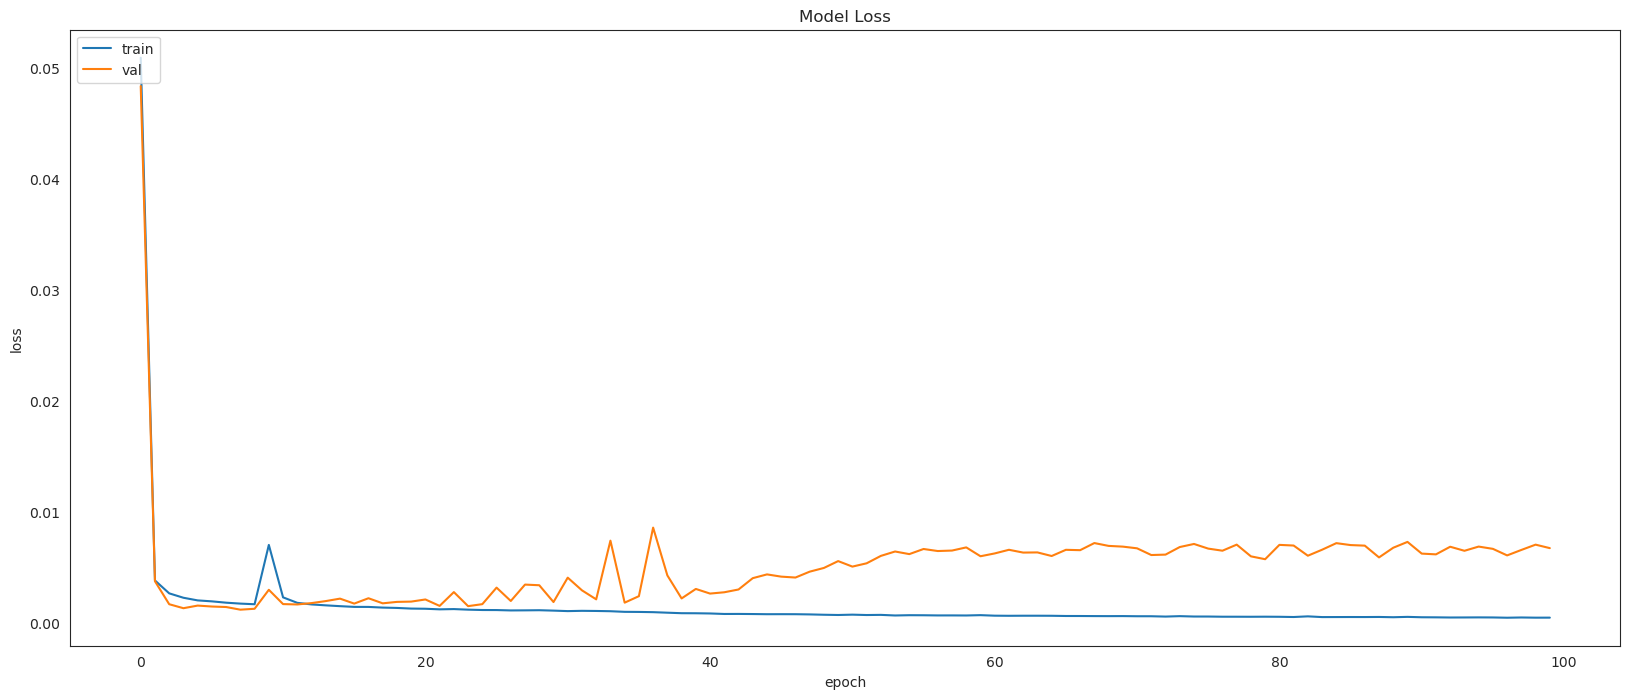

In [45]:
plt.figure(figsize=(20,8))
loss = history.history['loss']
val_loss = history.history['val_loss']
length = len(loss)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.xticks(range(16), range(5,21))

plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

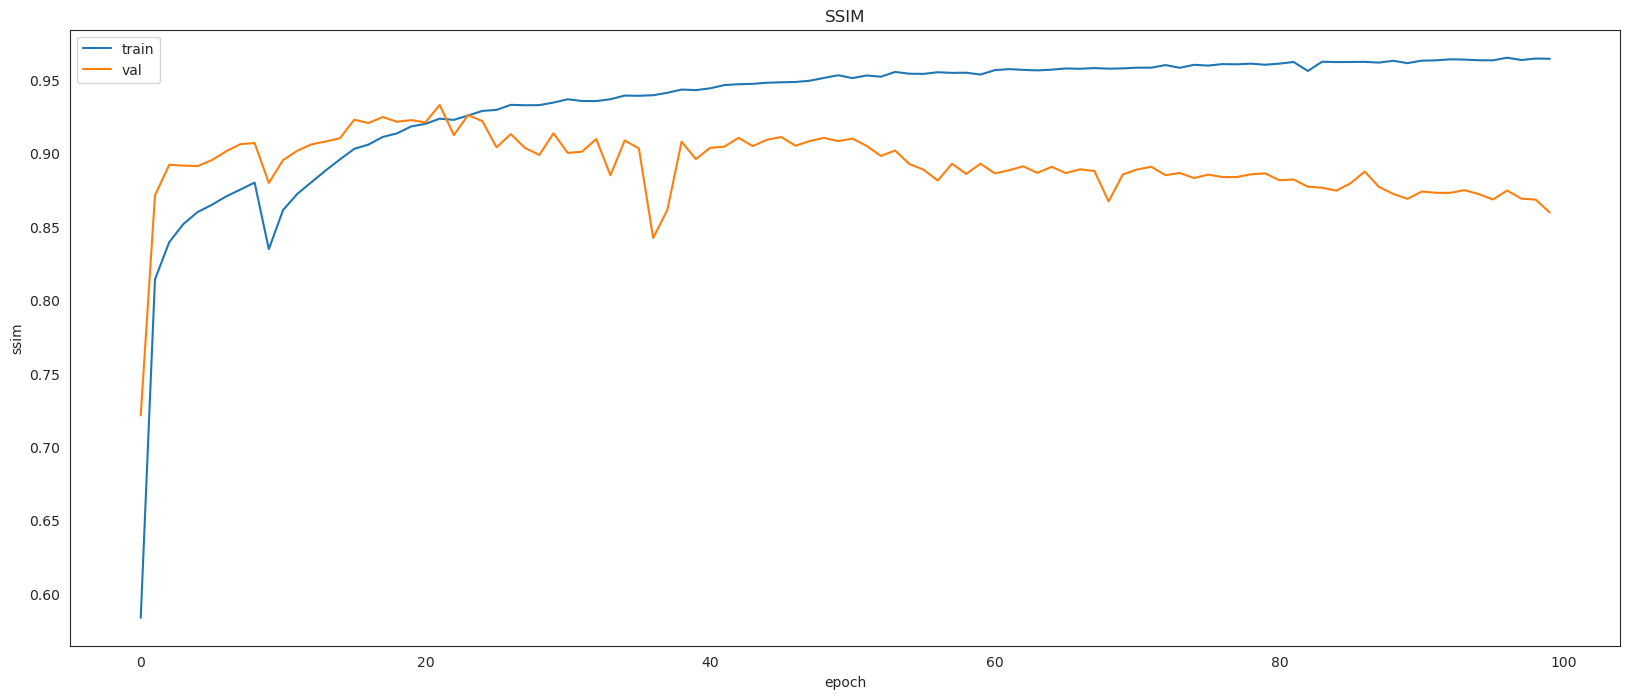

In [46]:
plt.figure(figsize=(20,8))
plt.plot(history.history['ssim'])
plt.plot(history.history['val_ssim'])
plt.title('SSIM')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
print('Max SSIM',max(history.history['ssim']))
print('Max Val SSIM',max(history.history['val_ssim']))
print('Min loss',min(history.history['loss']))
print('Min val loss',min(history.history['val_loss']))


Max SSIM 0.9648973941802979
Max Val SSIM 0.9327447414398193
Min loss 0.0004873853176832199
Min val loss 0.001212031813338399


In [52]:
random_val_samples = val_generator.__next__()
val_image_samples = random_val_samples[0]
val_mask_samples = random_val_samples[1]
predicted_masks = model.predict(val_image_samples)

NameError: name 'model' is not defined

In [1]:
fig, axs = plt.subplots(1 , 3, figsize=(20,4))
axs[0].imshow(random_val_samples[0][0])
axs[0].set_title('Input Image')
axs[1].imshow(val_mask_samples[0])
axs[1].set_title('Actual Image')
axs[2].imshow(predicted_masks[0])
axs[2].set_title('Reconstructed Image')

print(predicted_masks[0].shape)
print(val_mask_samples[0].shape)
print(random_val_samples[0][0].shape)
#cv2.imwrite(op_path + '/train_img.jpg',t_image)
#cv2.imwrite(op_path + '/actual_img.jpg', a_image)
#cv2.imwrite(op_path + '/predicted.jpg', image)


NameError: name 'plt' is not defined

In [23]:
p_image = (predicted_masks[0] * 255).astype(np.uint8)
a_image = (val_mask_samples[0] * 255).astype(np.uint8)
t_image = (random_val_samples[0][0] * 255).astype(np.uint8)


In [24]:
Ssim = []
n = 0
for i,m in test_generator:
    if n<304:
        img,mask = i,m
        pred = model.predict(i)
        acc = ssim(mask[0], pred[0])
        #print('SSIM: {}'.format(ssim(mask[0], pred[0])))
        Ssim.append(acc)
        n=n+1
    else:
        break

1/1 [==============================] - 0s 28ms/step


In [25]:
print(mask[0].shape)

(256, 256, 3)


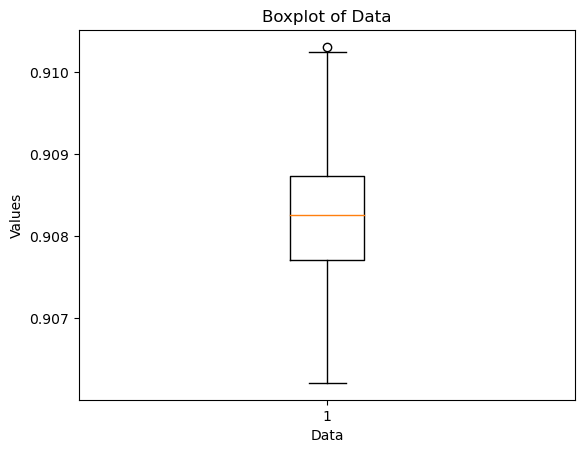

In [26]:
fig, ax = plt.subplots()

# Create a boxplot
ax.boxplot(Ssim)

# Set axis labels and title
ax.set_xlabel('Data')
ax.set_ylabel('Values')
ax.set_title('Boxplot of Data')

# Show the plot
plt.show()

1/1 [==============================] - 0s 25ms/step
SSIM: 0.9073789119720459
0.11235814
2.9802322e-08


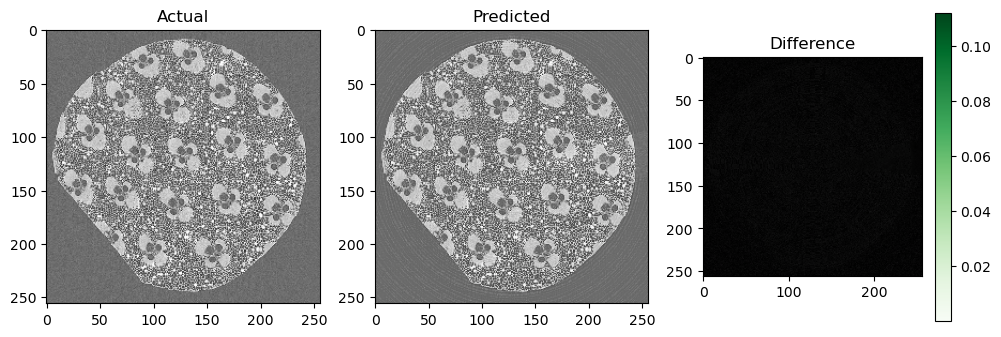

1/1 [==============================] - 0s 24ms/step
SSIM: 0.9089230895042419
0.10486829
5.9604645e-07


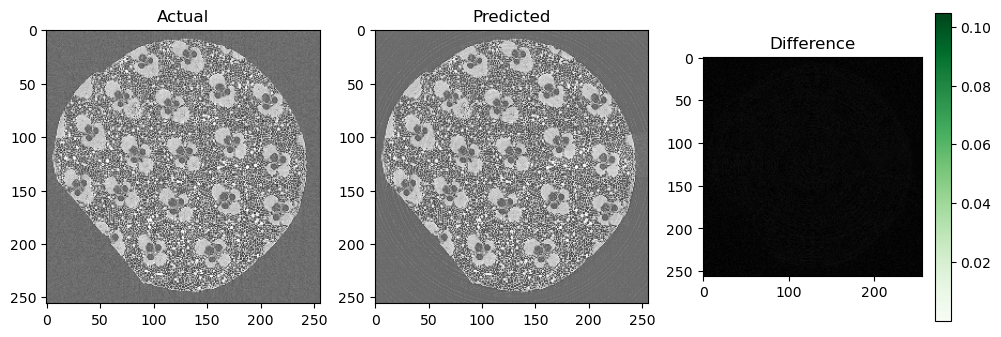

1/1 [==============================] - 0s 24ms/step
SSIM: 0.9071243405342102
0.10476476
1.1920929e-07


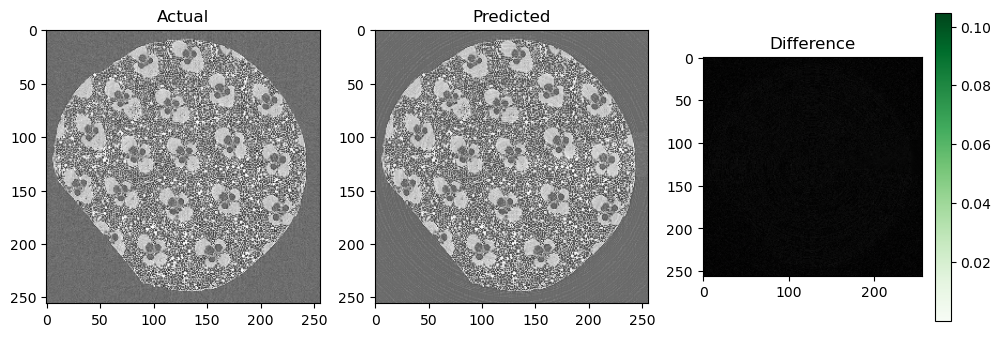

1/1 [==============================] - 0s 23ms/step
SSIM: 0.906888484954834
0.10105273
2.9802322e-07


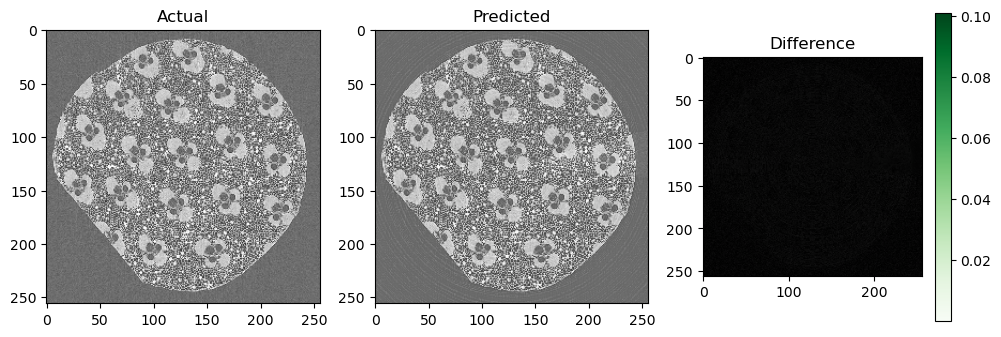

1/1 [==============================] - 0s 22ms/step
SSIM: 0.9079791903495789
0.100660026
5.9604645e-08


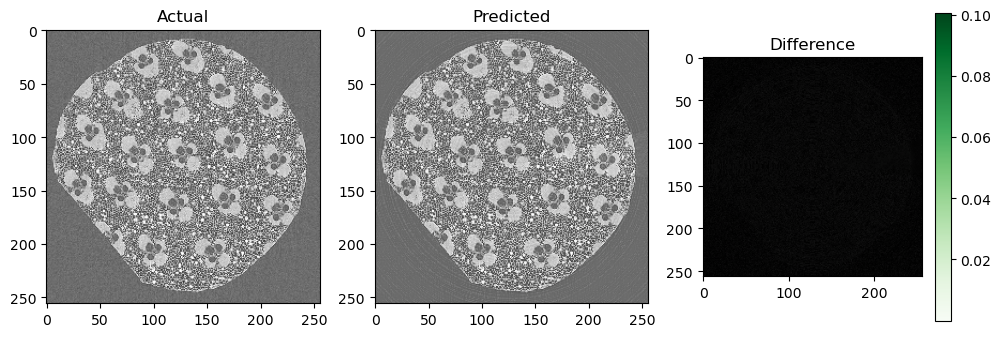

In [27]:
Ssim = []
n = 0
for i,m in test_generator:
    img,mask = i,m
    if n<5:
        pred = model.predict(i)
        acc = ssim(mask[0], pred[0])
        print('SSIM: {}'.format(ssim(mask[0], pred[0])))
        image1_array = mask[0]  # Get the NumPy array directly from the mask
        image2_array = pred[0]
        
        #image1_gray = mask[0].convert("L")
        #image2_gray = pred[0].convert("L")

# Convert the images to numpy arrays
        #image1_array = np.array(image1_gray)
        #image2_array = np.array(image2_gray)

# Compute the absolute difference between the two images
        diff_array = np.abs(image1_array - image2_array)
        #diff_array[0][3] = 1

# Find the maximum and minimum values in the difference matrix
        max_value = np.max(diff_array)
        min_value = np.min(diff_array)
        print(max_value)
        print(min_value)
        #max_value = 1
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(mask[0])
        axes[0].set_title("Actual")
        axes[1].imshow(pred[0])
        axes[1].set_title("Predicted")
        im = axes[2].imshow(diff_array, cmap="Greens", vmax=max_value, vmin=min_value)
        axes[2].set_title("Difference")
        plt.colorbar(im, ax=axes[2])

        # Display the plot
        plt.show()
        n+=1
    else:
        break